In [1]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [16]:
# get link of ads and non ads images
from os import walk

mypath_ads  = [
    "../data/dataset/ctpn_output/ads",
]
mypath_non_ads = [
    "../data/dataset/ctpn_output/non-ads"
]
def get_text_file(path_arr):
    filename = []
    name = []
    for path in path_arr:
        f = []
        for (dirpath, dirnames, filenames) in walk(path):
            f.extend(filenames)
            break
        filename+=[f"{path[1:]}/{i}" for i in f if "txt" in i]
        name+=[i for i in f if "txt" in i]
    return filename,name

In [17]:
ads, ads_name = get_text_file(mypath_ads)
non_ads,non_ads_name = get_text_file(mypath_non_ads)

Thống kê đánh giá dữ liệu

In [18]:
ads_data = []
for link in ads:
    ads_data.append([i[:-1] for i in open("."+ link,'r').readlines() if i !="\n"])
non_ads_data = []
for link in non_ads:
    non_ads_data.append([i[:-1] for i in open("."+ link,'r').readlines() if i !="\n"])
# ads_data = np.array(ads_data)
# non_ads_data = np.array(non_ads_data)


In [12]:
len_ads_data = np.array([len(i) for i in ads_data])
len_non_ads_data = np.array([len(i) for i in non_ads_data])
bb_ads = [sum(len_ads_data>i) for i in range(10,40)]
bb_non_ads = [sum(len_non_ads_data>i) for i in range(10,40)]


Text(0, 0.5, 'number of image')

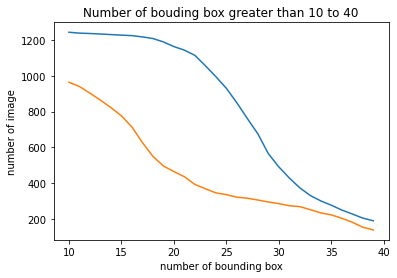

In [19]:
plt.plot(range(10,40),bb_ads,label="demo",)
plt.plot(range(10,40),bb_non_ads)
plt.title("Number of bouding box greater than 10 to 40")
plt.xlabel("number of bounding box")
plt.ylabel("number of image")

Get 10 bouding box - 5 greatest and 5 smallest

Get height and width of image

In [21]:
img_ads_path = "../data/dataset/training_data/ads"
img_non_ads_path = "../data/dataset/training_data/non_ads"
hw_ads = [PIL.Image.open(img_ads_path + "/" + name[:-3] + "png").size for name in ads_name]
hw_non_ads = [PIL.Image.open(img_non_ads_path +"/"+ name[:-3] + "png").size for name in non_ads_name]

Set weight of images

$$(H_b((|H_cb-H_c|+1)(|W_cb-W_c|+1)))/W_b$$

In [24]:
def extract_info(arr):
    arr = [int(i) for i in arr.split(",")[:-1]]
    h_b = arr[-1]-arr[1]
    w_b = arr[2] - arr[0]
    h_cb = (arr[-1]+arr[1])//2
    w_cb = (arr[2]+arr[0])//2
    return h_b,w_b,h_cb,w_cb

In [26]:
extract_info(ads_data[0][0])

(19, 64, 393, 544)

In [27]:
n_att = 10
w_ads = []
for bbs,hw in zip(ads_data,hw_ads):
    if len(bbs) <n_att:
        continue
    temp = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp.append(weight)
    temp = sorted(temp)
    w_ads.append(temp[-n_att:])
    # w_ads.append(temp[:5] + temp[-5:])
w_non_ads = []
for bbs,hw in zip(non_ads_data,hw_non_ads):
    if len(bbs) <n_att:
        continue
    temp = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp.append(weight)
    temp = sorted(temp)
    w_non_ads.append(temp[-n_att:])
    # w_non_ads.append(temp[:5] + temp[-5:])


In [28]:
X = w_ads + w_non_ads
y = [0]*len(w_ads) + [1]*len(w_non_ads)


In [29]:
len(w_non_ads)

975

# Using Neural Netwwork

In [30]:
from keras.models import Sequential
from keras.layers import Dense

In [31]:
# define the keras model
model =Sequential()
model.add(Dense(16, input_dim=n_att, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [32]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.fit(X,y,epochs=10,batch_size=10)

Epoch 1/10
222/222 [==============================] - 1s 1ms/step - loss: 587.8297 - accuracy: 0.4932
Epoch 2/10
222/222 [==============================] - 0s 1ms/step - loss: 126.4844 - accuracy: 0.5221
Epoch 3/10
222/222 [==============================] - 0s 1ms/step - loss: 71.6799 - accuracy: 0.5284
Epoch 4/10
222/222 [==============================] - 0s 1ms/step - loss: 59.4030 - accuracy: 0.5131
Epoch 5/10
222/222 [==============================] - 0s 1ms/step - loss: 43.8039 - accuracy: 0.5086
Epoch 6/10
222/222 [==============================] - 0s 1ms/step - loss: 19.2368 - accuracy: 0.5261
Epoch 7/10
222/222 [==============================] - 0s 1ms/step - loss: 17.0076 - accuracy: 0.5122
Epoch 8/10
222/222 [==============================] - 0s 2ms/step - loss: 19.1769 - accuracy: 0.5054
Epoch 9/10
222/222 [==============================] - 0s 2ms/step - loss: 25.0327 - accuracy: 0.5257
Epoch 10/10
222/222 [==============================] - 0s 1ms/step - loss: 8.6387 - accur

In [35]:
predictions = model.predict(X[:5])
# summarize the first 5 cases
# for i in range(5):
# 	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))

In [37]:
print("{}/{}".format(sum(predictions < 0.5)[0], len(predictions)))
print(sum(y[:5]))

5/5
0


#   Using SVM

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as metrics

In [35]:
X_train , X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

In [36]:
clf = SVC(C=1.0, kernel='rbf').fit(X_train,y_train)

In [37]:
len(X_train)

1552

In [38]:
y_pred = clf.predict(X_test)

In [39]:
metrics.confusion_matrix(y_test,y_pred)

array([[307,  75],
       [ 51, 233]], dtype=int64)

In [40]:
accuracy = 0
for i in range(len(y_pred)):
    accuracy += y_pred[i] == y_test[i]
print("accuracy:{}  {}/{}".format(accuracy/len(y_pred),accuracy, len(y_pred)))

accuracy:0.8108108108108109  540/666


In [43]:
len(hw_non_ads)

981

## Save SVM support vectors

In [47]:
import joblib

In [48]:
joblib.dump(clf, "svm_phase_1.pkl")

['svm_phase_1.pkl']

## Load SVM by joblid

In [50]:
clf2 = joblib.load("svm_phase_1.pkl")

In [51]:
r = clf2.predict(X_test)

In [55]:
metrics.confusion_matrix(y_test, r)

array([[307,  75],
       [ 51, 233]], dtype=int64)